In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock
import nltk

import seaborn as sns

In [31]:
def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query
    
    Parameters
    ----------
    query : ndarray
        query object represented in the same form vector representation as the
        objects
    objects : ndarray
        vector-represented objects in the database; rows correspond to 
        objects, columns correspond to features
    k : int
        number of most similar objects to return
    dist : function
        accepts two ndarrays as parameters then returns their distance
    
    Returns
    -------
    ndarray
        Indices to the most similar objects in the database
    """
    return np.argsort([dist(query, o) for o in objects])[:k]

In [32]:
def inverse_transform(text_query):
    """Codes copied from data_building_and_cleaning. Credits to the 
    rightful owner."""
    
    import string
    punc = string.punctuation.replace('-', '').replace("'", '')
    table = str.maketrans(' ', ' ', punc)
    stripped = [w.translate(table) for w in [text_query.lower()]]

    ######################################################################

    # filter out stop words
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words('english'))

    no_stop_words = []
    for word_list in stripped:
        word_list = word_list.split()
        words = [w for w in word_list if not w in stop_words]
        no_stop_words += [words]

    ######################################################################

    # nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer 

    lemmatizer = WordNetLemmatizer() 

    lematized = []
    for word_list in no_stop_words:
        words = [lemmatizer.lemmatize(w) for w in word_list]
        lematized += [words]

    title_cleaned = []
    for i in lematized:
        title_cleaned+=[" ".join(i)]

    return title_cleaned[0]

In [33]:
df_clean = pd.read_pickle('../data_cleaning/clusters_added.pkl')

In [34]:
df_clean['congress'].unique()

array([13, 14, 15, 16, 17, 18])

## Parameters

In [35]:
text_query = 'death penalty'
k = 5


bill_num = None
filed_by = None
scope = None
min_file_date = None
max_file_date = None
primary_committee = None
congress = list(range(13,19))

# congess filed_by scope filed_on primary_committee
filtered = {}
for i in congress:
    filtered[i] = df_clean.query(f"congress == {congress} ").copy()

### Vectorization and IDF scaling

In [36]:
tfidf = TfidfVectorizer(stop_words='english', min_df=0.001, max_df=0.999)

X_idf = {}
X_feat_names = {}

for i in congress:
    X_idf[i] = tfidf.fit_transform(filtered[i]['combined_title']).toarray()
    X_feat_names[i] = tfidf.get_feature_names()

In [28]:
## sample querying
query = [inverse_transform(text_query)]                    
print(query[0])                          
search_results = nearest_k(tfidf.transform(query).toarray()[0], X_idf, k, cosine)
pd.set_option('display.max_colwidth', None)
print(f'Top {k} search results:\n\n')
i = 1
filtered.iloc[search_results]

death penalty
Top 5 search results:




AttributeError: 'dict' object has no attribute 'iloc'

In [ ]:
# improve query using filter
# Verify performance using AUC-PR of Scope and Primary Committee
# Seach committee sample, AUC-PR
# Verify with 5 randomized search terms, manually. Compare from government website 
# Show power with 'minimum wage' manual

## AUC-PR

## Scope per Congress Number

In [40]:
from tqdm import tqdm
from collections import defaultdict

dist = euclidean # can also be changed to manhattan, cosine gives an error

pres = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}
rec = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}

for i in congress[1:2]:
    for s in tqdm(range(50)):  # 100 is arbitrary, can be changed
        nearest = filtered[i].iloc[nearest_k(X_idf[i][s, :], X_idf[i], filtered[i].shape[0], dist)]
        r = np.cumsum(nearest['scope'] == filtered[i]['scope'].iloc[s])
        precision = r/np.arange(1, len(r)+1)
        n = sum(filtered[i]['scope'] == filtered[i]['scope'].iloc[s])
        recall = r/n
        recall = [0] + recall.tolist()
        precision = [1] + precision.tolist()
        pres[i][s].append(precision)
        rec[i][s].append(recall)

100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


0.8999248735471833


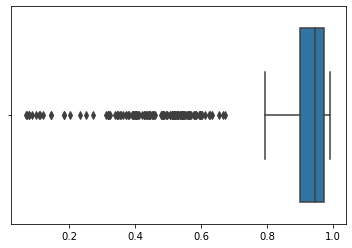

In [16]:
mean_auc_roc = defaultdict(list)
for key in pres.keys():
    mean_auc_roc[key].append(np.trapz(pres[key], rec[key])[0])

all_auc_roc = [i[0] for i in mean_auc_roc.values()]
    
sns.boxplot(all_auc_roc)

print(np.mean(all_auc_roc))

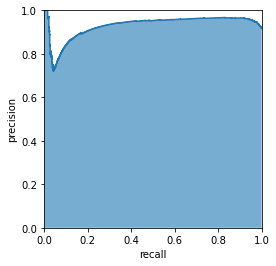

The Area is 0.932801684369982


In [17]:
# sample AUC-ROC curve
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in congress:
    key = list(pres[i].keys())[0]

    ax_list[i-13].set_aspect('equal')
    ax_list[i-13].step(rec[i][key][0], pres[i][key][0], where='post')
    ax_list[i-13].fill_between(rec[i][key][0], pres[i][key][0], step='post', alpha=0.6)

    ax_list[i-13].set_xlim(0, 1)
    ax_list[i-13].set_ylim(0, 1)

    ax_list[i-13].set_xlabel('recall')
    ax_list[i-13].set_ylabel('precision')
    ax_list[i-13].set_title(f'AUC-PR for {i}th Congress')
    ax_list[i-13].text(0.65, 0.8,
        'AUC={:0.2f}'.format(
            np.trapz(pres[i][key][0], rec[i][key][0])),
         fontsize=12);
    
plt.show()

# print(f'The Area is {}') 

## Primary Committee per Congress Number

In [11]:
from tqdm import tqdm
from collections import defaultdict

dist = euclidean # can also be changed to manhattan, cosine gives an error

pres = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}
rec = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}

for i in congress:
    for s in tqdm(range(filtered[i].shape[0])):  # 100 is arbitrary, can be changed
        nearest = filtered[i].iloc[nearest_k(X_idf[i][s, :], X_idf[i], filtered[i].shape[0], dist)]
        r = np.cumsum(nearest['primary_committee'] == filtered[i]['primary_committee'].iloc[s])
        precision = r/np.arange(1, len(r)+1)
        n = sum(filtered[i]['primary_committee'] == filtered[i]['primary_committee'].iloc[s])
        recall = r/n
        recall = [0] + recall.tolist()
        precision = [1] + precision.tolist()
        pres[i][s].append(precision)
        rec[i][s].append(recall)

  1%|          | 140/15239 [00:31<57:20,  4.39it/s] 


KeyboardInterrupt: 

0.23657737903905263


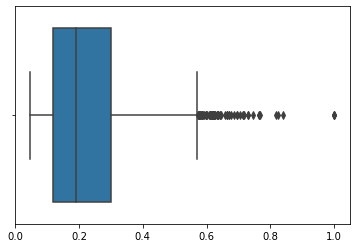

In [19]:
mean_auc_roc = defaultdict(list)
for key in pres.keys():
    mean_auc_roc[key].append(np.trapz(pres[key], rec[key])[0])

all_auc_roc = [i[0] for i in mean_auc_roc.values()]
    
sns.boxplot(all_auc_roc)

print(np.mean(all_auc_roc))

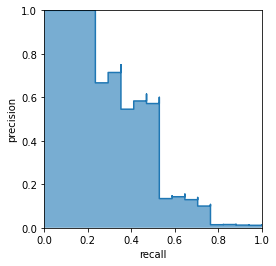

The Area is 0.4561695418593995


In [20]:
# sample AUC-ROC curve

key = list(pres.keys())[0]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.step(rec[key][0], pres[key][0], where='post')
ax.fill_between(rec[key][0], pres[key][0], step='post', alpha=0.6)
    
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
    
ax.set_xlabel('recall')
ax.set_ylabel('precision')
plt.show()

print(f'The Area is {np.trapz(pres[key][0], rec[key][0])}')

In [31]:
cols = ['bill_num', 'title', 'filed_by']
df = pd.read_pickle("../data_cleaning/labor.pkl")[cols]

In [32]:
df

,bill_num,title,filed_by
14144,240,EXCISE TAX ON MINERAL PRODUCTS,"[Sotto III, Vicente C, ]"
9424,748,TAX REFORM ACT,"[Ejercito-Estrada, Jinggoy P, ]"
1836,1838,VAT EXEMPT ON CERTAIN FOOD PRODUCTS/SERVICES,"[Drilon, Franklin M, , Flavier, Juan M, , Pangilinan, Francis N, , Gordon, Richard ""Dick"" J, ]"
6225,546,VALUE ADDED TAX ON DONATED IMPORTATIONS OF ITEMS OR GOODS,"[Ejercito-Estrada, Jinggoy P, ]"
9914,1238,PUBLIC SCHOOL TEACHERS' TAX INCENTIVE,"[Sotto III, Vicente C, ]"


**Manual**

In [54]:
from tqdm import tqdm
from collections import defaultdict

dist = euclidean # can also be changed to manhattan, cosine gives an error

pres = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}
rec = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}

text_query = 'minimum wage'
query = [inverse_transform(text_query)]    
for i in congress[1:2]:
    for s in tqdm(range(50)):  # 100 is arbitrary, can be changed
        nearest = filtered[i].iloc[nearest_k(tfidf.transform(query).toarray()[0], X_idf[i], 5, dist)]
        r = np.cumsum(nearest['scope'] == filtered[i]['scope'].iloc[s])
        precision = r/np.arange(1, len(r)+1)
        n = sum(filtered[i]['scope'] == filtered[i]['scope'].iloc[s])
        recall = r/n
        recall = [0] + recall.tolist()
        precision = [1] + precision.tolist()
        pres[i][s].append(precision)
        rec[i][s].append(recall)

################################################################

print(f'minimum wage precision: {np.mean(pres[14][key][0])}')
print(f'minimum wage recall: %.5f'%(np.mean(rec[14][key][0])))

100%|██████████| 50/50 [00:10<00:00,  4.63it/s]

minimum wage precision: 1.0
minimum wage recall: 0.00017


In [52]:
print(f'minimum wage precision: {np.mean(pres[14][key][0])}')
print(f'minimum wage recall: %.5f'%(np.mean(rec[14][key][0])))

precision: 1.0
recall: 0.00017


In [53]:
from tqdm import tqdm
from collections import defaultdict

dist = euclidean # can also be changed to manhattan, cosine gives an error

pres = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}
rec = {13:defaultdict(list), 14:defaultdict(list), 15:defaultdict(list), 
        16:defaultdict(list), 17:defaultdict(list), 18:defaultdict(list)}

query = [inverse_transform('overseas filipino workers')]    
for i in congress[1:2]:
    for s in tqdm(range(50)):  # 100 is arbitrary, can be changed
        nearest = filtered[i].iloc[nearest_k(tfidf.transform(query).toarray()[0], X_idf[i], 5, dist)]
        r = np.cumsum(nearest['scope'] == filtered[i]['scope'].iloc[s])
        precision = r/np.arange(1, len(r)+1)
        n = sum(filtered[i]['scope'] == filtered[i]['scope'].iloc[s])
        recall = r/n
        recall = [0] + recall.tolist()
        precision = [1] + precision.tolist()
        pres[i][s].append(precision)
        rec[i][s].append(recall)

100%|██████████| 50/50 [00:11<00:00,  4.54it/s]
